In [1]:
import os

network_path = os.path.join("networks", "FS_SPN_feed_forward")

input_name = "FS_SPN_feed_forward"
sim_file_gj = os.path.join(network_path, "simulation", f"output-GJ-{input_name}.hdf5")
sim_file_nogj = os.path.join(network_path, "simulation", f"output-noGJ-{input_name}.hdf5")

fig_path = os.path.join(network_path, "figures")

input_config = f"{input_name}-input.json"
duration=3
osc_freq = 20

# Number of cores to use for NEURON
n_cores = 3

modified_network = os.path.join(network_path, "network-synapses-ablated.hdf5")

In [ ]:
from snudda.init import SnuddaInit

from snudda.init.init import SnuddaInit
cnc = SnuddaInit(struct_def={}, network_path=network_path, random_seed=1337,
                 snudda_data="../../../../BasalGangliaData/data/")
# To get only FS density we would use 0.013*80500, but then we also have dSPN and iSPN here in network
# so we need to compensate to get the correct FS neuron density (which is the important part)

num_FS = 400
num_dSPN_orig = 800
num_iSPN_orig = 800
num_dSPN_final = 40
num_iSPN_final = 40

cnc.define_striatum(num_dSPN=num_dSPN_orig, num_iSPN=num_iSPN_orig, num_FS=num_FS, num_LTS=0, num_ChIN=0,
                    volume_type="cube", neuron_density=0.013*80500*(1 + (num_dSPN_orig + num_iSPN_orig)/num_FS))
cnc.add_population_unit_random("Striatum", "FS", 1.0, 1)
cnc.write_json()

In [ ]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

In [ ]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, verbose=False)
sd.detect()

In [ ]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()

### Ablating network
It is important that the SPN networks receive a full set of FS inputs, so we want to only keep the SPN that are in the core.

In [ ]:
from snudda.utils import SnuddaLoad
from snudda.utils.ablate_network import SnuddaAblateNetwork
mod_network = SnuddaAblateNetwork(network_file=os.path.join(network_path, "network-synapses.hdf5"))
orig_sl = SnuddaLoad(network_path)
orig_fs_id = orig_sl.get_neuron_id_of_type("FS")
orig_dspn_id = [x for x, y in orig_sl.get_centre_neurons_iterator(neuron_type="dSPN", n_neurons=num_dSPN_final)]
orig_ispn_id = [x for x, y in orig_sl.get_centre_neurons_iterator(neuron_type="iSPN", n_neurons=num_iSPN_final)]

keep_id = set(list(orig_fs_id) + list(orig_dspn_id) + list(orig_ispn_id)) 
mod_network.only_keep_neuron_id(keep_id)
mod_network.write_network(modified_network)

In [ ]:
from snudda.plotting.plot_network import PlotNetwork
pn = PlotNetwork(modified_network)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)

In [ ]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path,
                 hdf5_network_file=modified_network,
                 input_config_file=f"{input_name}-input.json",
                 verbose=False)
si.generate()

In [ ]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file, network_path=modified_network)
spi.plot_input(neuron_type="FS", num_neurons=3)
spi.plot_input(neuron_type="dSPN", num_neurons=2)
spi.plot_input(neuron_type="iSPN", num_neurons=2)

In [ ]:
os.system(f"mpiexec -n {n_cores} snudda simulate {network_path} --networkFile {modified_network} --time {duration} --outputFile {sim_file_gj}")

In [ ]:
os.system(f"mpiexec -n {n_cores} snudda simulate {network_path} --networkFile {modified_network} --time {duration} --outputFile {sim_file_nogj} --disableGJ")

### Figures

In [2]:
from snudda.utils import SnuddaLoad
from snudda.utils import SnuddaLoadNetworkSimulation

sl = SnuddaLoad(modified_network)
sls_gj = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file_gj)
sls_nogj = SnuddaLoadNetworkSimulation(network_simulation_output_file=sim_file_nogj)

n_centre=10

nid_fs = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="FS")]
nid_dspn = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="dSPN")]
nid_ispn = [x for x,y in sl.get_centre_neurons_iterator(n_neurons=n_centre, neuron_type="iSPN")]

Loading 360 neurons with 9814 synapses and 1257 gap junctions
Loading networks/FS_SPN_feed_forward/simulation/output-GJ-FS_SPN_feed_forward.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
9: (FS_1, p31916918, meffc0dfa)
14: (FS_3, p92705ff4, m15ae4048)
22: (FS_0, p4feff98b, m4cd420e2)
37: (FS_1, p6eb0c221, macdedfff)
40: (FS_1, pf9439e45, macdedfff)
55: (FS_0, p4feff98b, m86da4874)
70: (FS_1, pf9439e45, m9d1605c7)
81: (dSPN_1, p81757e87, m7fe0fbde)
94: (FS_0, p59a48310, m15ae4048)
95: (FS_0, p4feff98b, m86da4874)
108: (FS_0, p4feff98b, m86da4874)
112: (FS_0, p4feff98b, m86da4874)
117: (iSPN_0, pfb05971b, m6486ed26)
121: (FS_0, p4feff98b, m4fdebda2)
124: (dSPN_0, pe1ec8fbd, m22be6817)
131: (FS_1, pf86c86e4, m868d56db)
132: (FS_1, pf86c86e4, m48f576bb)
142: (FS_0, p4feff98b, m4cd420e2)
151: (FS_0, p59a48310, me486b19e)
157: (iSPN_0, p581376d6, md0f5647c)
166: (FS_0, p59a48310, m86da4874)
169: (FS_1, pf9439e45, mf0a83676)
189: (iSPN_0, p635

Loading network info from networks/FS_SPN_feed_forward/network-synapses-ablated.hdf5
Loading 360 neurons with 9814 synapses and 1257 gap junctions
Loading input info from networks/FS_SPN_feed_forward/input-spikes.hdf5
Loading networks/FS_SPN_feed_forward/simulation/output-GJ-FS_SPN_feed_forward.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
9: (FS_1, p31916918, meffc0dfa)
14: (FS_3, p92705ff4, m15ae4048)
22: (FS_0, p4feff98b, m4cd420e2)
37: (FS_1, p6eb0c221, macdedfff)
40: (FS_1, pf9439e45, macdedfff)
55: (FS_0, p4feff98b, m86da4874)
70: (FS_1, pf9439e45, m9d1605c7)
81: (dSPN_1, p81757e87, m7fe0fbde)
94: (FS_0, p59a48310, m15ae4048)
95: (FS_0, p4feff98b, m86da4874)
108: (FS_0, p4feff98b, m86da4874)
112: (FS_0, p4feff98b, m86da4874)
117: (iSPN_0, pfb05971b, m6486ed26)
121: (FS_0, p4feff98b, m4fdebda2)
124: (dSPN_0, pe1ec8fbd, m22be6817)
131: (FS_1, pf86c86e4, m868d56db)
132: (FS_1, pf86c86e4, m48f576bb)
142: (FS_0, p4feff98b, m4cd420e2)


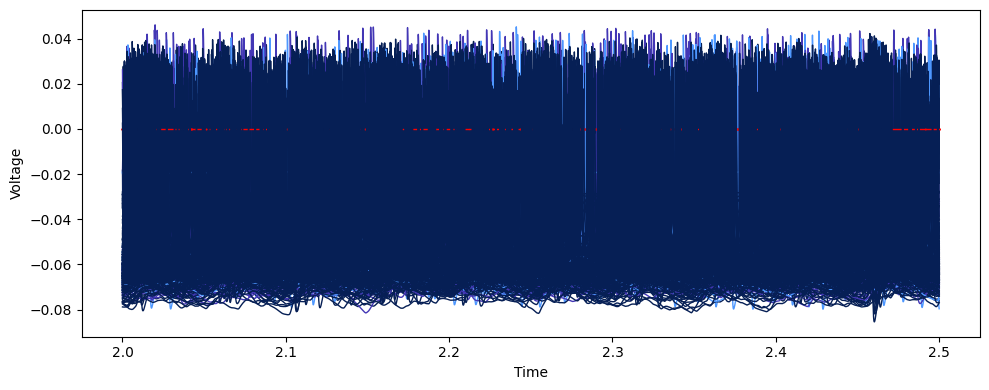

In [3]:
%matplotlib inline

from snudda.plotting.plot_traces import PlotTraces
pt = PlotTraces(output_file=sim_file_gj, network_file=modified_network)
# Use trace_id to specify which traces
ax = pt.plot_traces(offset=0, time_range=(2,2.5),fig_size=(10,4))

Loading network info from networks/FS_SPN_feed_forward/network-synapses-ablated.hdf5
Loading 360 neurons with 9814 synapses and 1257 gap junctions
Loading input info from networks/FS_SPN_feed_forward/input-spikes.hdf5
Loading networks/FS_SPN_feed_forward/simulation/output-noGJ-FS_SPN_feed_forward.hdf5
WARNING. Depolarisation block in neuron - neuron_id: (name, parameter_key, morphology_key):
9: (FS_1, p31916918, meffc0dfa)
17: (FS_0, p59a48310, me486b19e)
31: (FS_0, p4feff98b, m4fdebda2)
55: (FS_0, p4feff98b, m86da4874)
81: (dSPN_1, p81757e87, m7fe0fbde)
90: (FS_1, p31916918, macdedfff)
94: (FS_0, p59a48310, m15ae4048)
95: (FS_0, p4feff98b, m86da4874)
112: (FS_0, p4feff98b, m86da4874)
117: (iSPN_0, pfb05971b, m6486ed26)
142: (FS_0, p4feff98b, m4cd420e2)
151: (FS_0, p59a48310, me486b19e)
157: (iSPN_0, p581376d6, md0f5647c)
189: (iSPN_0, p635b801c, m3a845add)
199: (dSPN_1, p81757e87, m7fe0fbde)
202: (FS_0, pb1ef6b01, m4cd420e2)
203: (FS_0, p4feff98b, m4cd420e2)
241: (FS_1, pf86c86e4, m9d

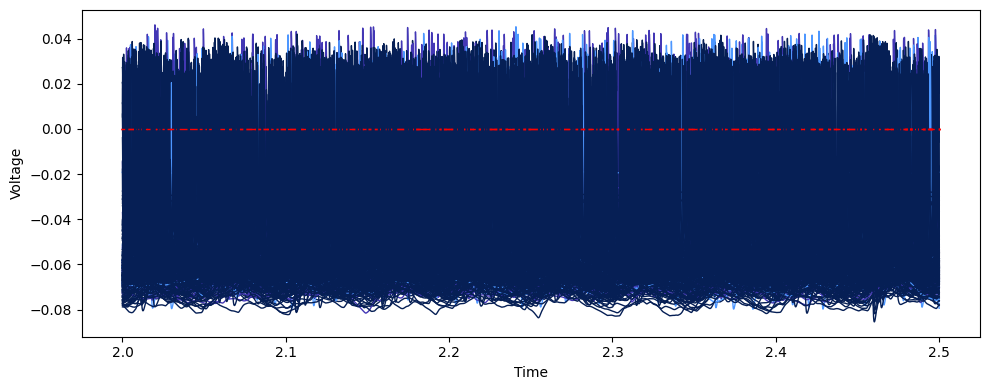

In [4]:
from snudda.plotting.plot_traces import PlotTraces
pt2 = PlotTraces(output_file=sim_file_nogj, network_file=modified_network)
ax2 = pt2.plot_traces(offset=0, time_range=(2,2.5),fig_size=(10,4))

Writing figure to networks/FS_SPN_feed_forward/figures/Period-histogram-FS_SPN_feed_forward-GJ.png


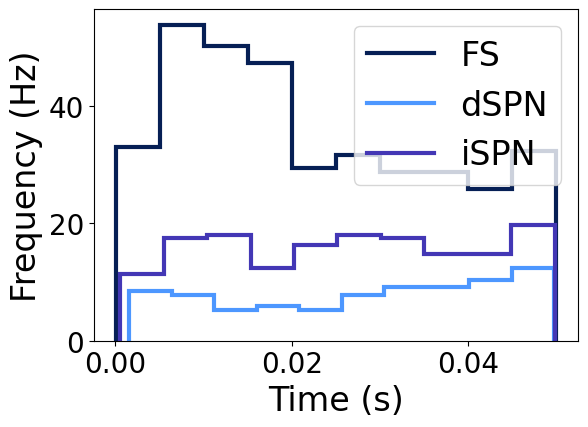

In [5]:
from snudda.plotting import SnuddaPlotSpikeRaster2
spr = SnuddaPlotSpikeRaster2(network_path=network_path,
                             network_file=modified_network,
                             simulation_file=sim_file_gj,
                             snudda_load=sl, snudda_simulation_load=sls_gj)
time_range = (1,3)
fig_name_ph_gj = f"Period-histogram-{input_name}-GJ.png"
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, time_range=time_range, label="FS", color=spr.get_colours("FS"), show_figure=False,
                                         exclude_depolarisation_blocked_neurons=True, save_figure=False)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, time_range=time_range, label="dSPN", ax=ax, color=spr.get_colours("dSPN"), show_figure=False,
                                        exclude_depolarisation_blocked_neurons=True, save_figure=False)
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, time_range=time_range, label="iSPN", ax=ax, color=spr.get_colours("iSPN"),
                                        exclude_depolarisation_blocked_neurons=True, fig_file=fig_name_ph_gj)

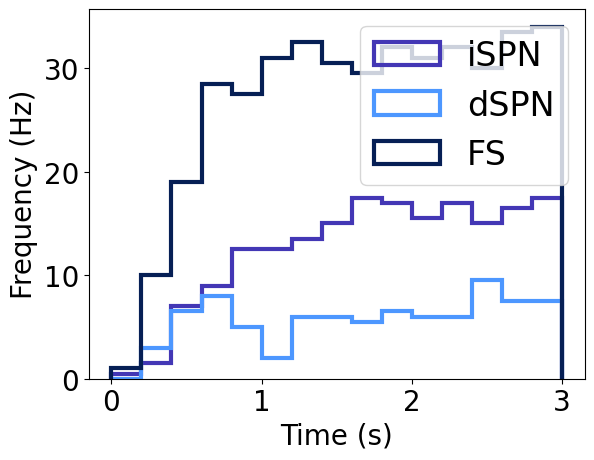

In [6]:
fig_name_sh_gj = f"{input_name}-spike-histogram-GJ.png"
spr.plot_spike_histogram_type(["FS", "dSPN", "iSPN"], bin_size=200e-3, n_core=10, fig_file=fig_name_sh_gj, linestyle="-")

Writing figure to networks/FS_SPN_feed_forward/figures/Period-histogram-FS_SPN_feed_forward-noGJ.png


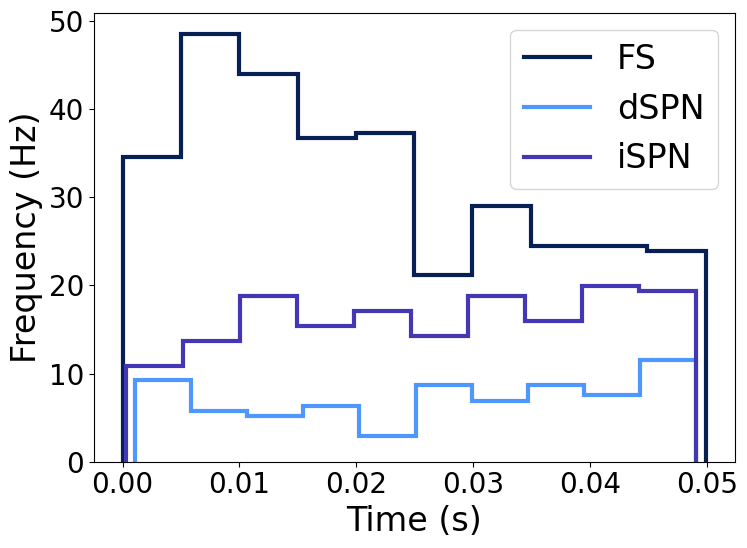

In [7]:
from snudda.plotting import SnuddaPlotSpikeRaster2
spr2 = SnuddaPlotSpikeRaster2(network_path=network_path, 
                              network_file=modified_network,
                              simulation_file=sim_file_nogj,
                              snudda_load=sl, snudda_simulation_load=sls_nogj)

fig_name_ph_nogj = f"Period-histogram-{input_name}-noGJ.png"
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, time_range=time_range, label="FS", color=spr.get_colours("FS"), show_figure=False,
                                          exclude_depolarisation_blocked_neurons=True, save_figure=False, fig_size=(8,6))
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, time_range=time_range, label="dSPN", ax=ax, color=spr.get_colours("dSPN"), show_figure=False,
                                         exclude_depolarisation_blocked_neurons=True, save_figure=False)
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, time_range=time_range, label="iSPN", ax=ax, color=spr.get_colours("iSPN"),
                                         exclude_depolarisation_blocked_neurons=True, fig_file=fig_name_ph_nogj)

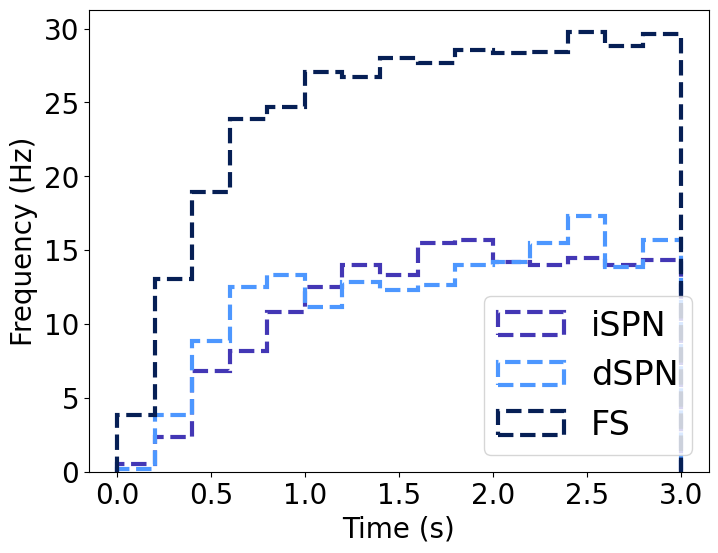

In [8]:
fig_name_sh_nogj = f"{input_name}-spike-histogram-noGJ.png"

spr2.plot_spike_histogram_type(["FS", "dSPN", "iSPN"], bin_size=200e-3, fig_file=fig_name_sh_nogj, linestyle="--", legend_loc="lower right", fig_size=(8,6))

Comparing with and without gap junctions

Writing figure to networks/FS_SPN_feed_forward/figures/Period-histogram-FS_SPN_feed_forward-summary.png


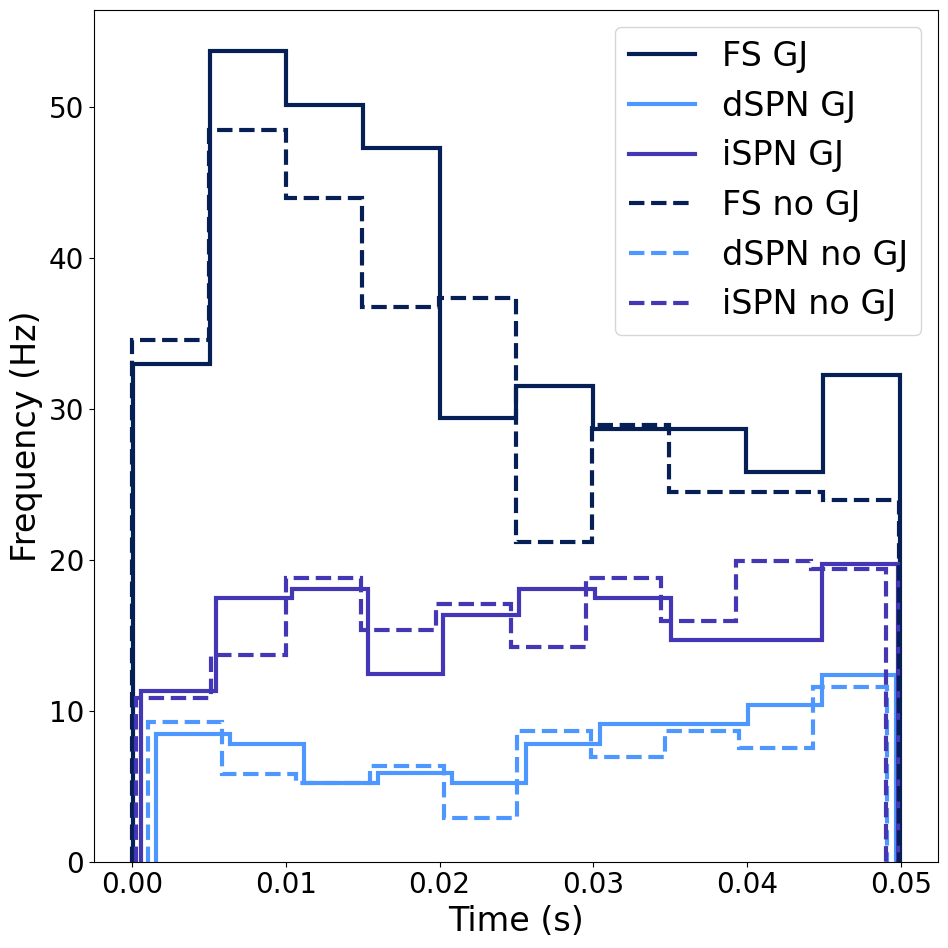

In [9]:
fig_name_ph = f"Period-histogram-{input_name}-summary.png"
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, time_range=time_range, label="FS GJ", color=spr.get_colours("FS"), show_figure=False, fig_size=(10,10),
                                         exclude_depolarisation_blocked_neurons=True, save_figure=False, linestyle="-")
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, time_range=time_range, label="dSPN GJ", ax=ax, color=spr.get_colours("dSPN"), show_figure=False,
                                        exclude_depolarisation_blocked_neurons=True, save_figure=False, linestyle="-")
ax, _, _ = spr.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, time_range=time_range, label="iSPN GJ", ax=ax, color=spr.get_colours("iSPN"), show_figure=False,
                                        exclude_depolarisation_blocked_neurons=True, save_figure=False, linestyle="-")
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_fs, period=1/osc_freq, time_range=time_range, label="FS no GJ", ax=ax, color=spr.get_colours("FS"), show_figure=False,
                                          exclude_depolarisation_blocked_neurons=True, save_figure=False, linestyle="--")
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_dspn, period=1/osc_freq, time_range=time_range, label="dSPN no GJ", ax=ax, color=spr.get_colours("dSPN"), show_figure=False,
                                         exclude_depolarisation_blocked_neurons=True, save_figure=False, linestyle="--")
ax, _, _ = spr2.plot_period_histogram_mod(neuron_id=nid_ispn, period=1/osc_freq, time_range=time_range, label="iSPN no GJ", ax=ax, color=spr.get_colours("iSPN"),
                                         exclude_depolarisation_blocked_neurons=True, fig_file=fig_name_ph, linestyle="--")

Saving figure to networks/FS_SPN_feed_forward/figures/FS_SPN_feed_forward-spike-raster-GJ.png


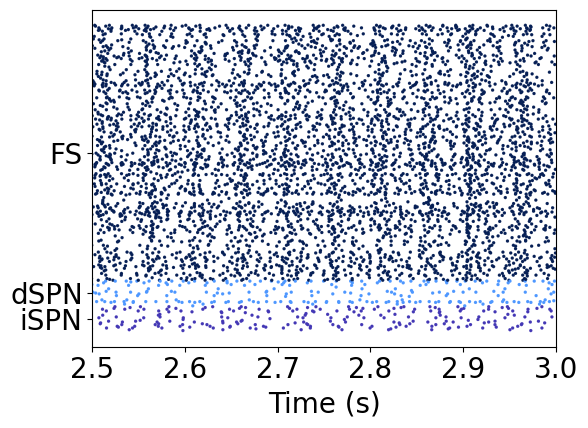

Saving figure to networks/FS_SPN_feed_forward/figures/FS_SPN_feed_forward-spike-raster-noGJ.png


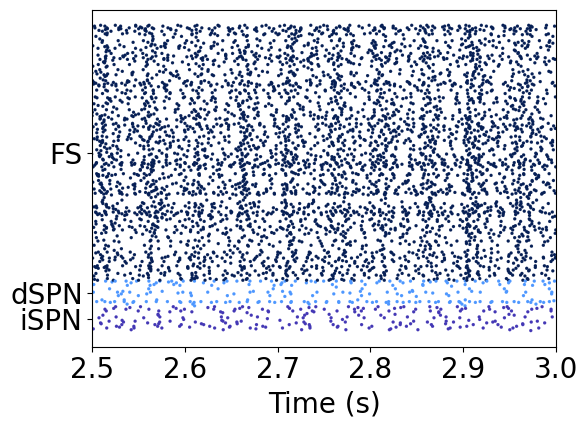

In [10]:
fig_file_raster_gj = f"{input_name}-spike-raster-GJ.png"
fig_file_raster_nogj = f"{input_name}-spike-raster-noGJ.png"

time_range_zoom = (2.5,3)

spr.plot_spike_raster(fig_file=fig_file_raster_gj, time_range=time_range_zoom)
spr2.plot_spike_raster(fig_file=fig_file_raster_nogj, time_range=time_range_zoom)

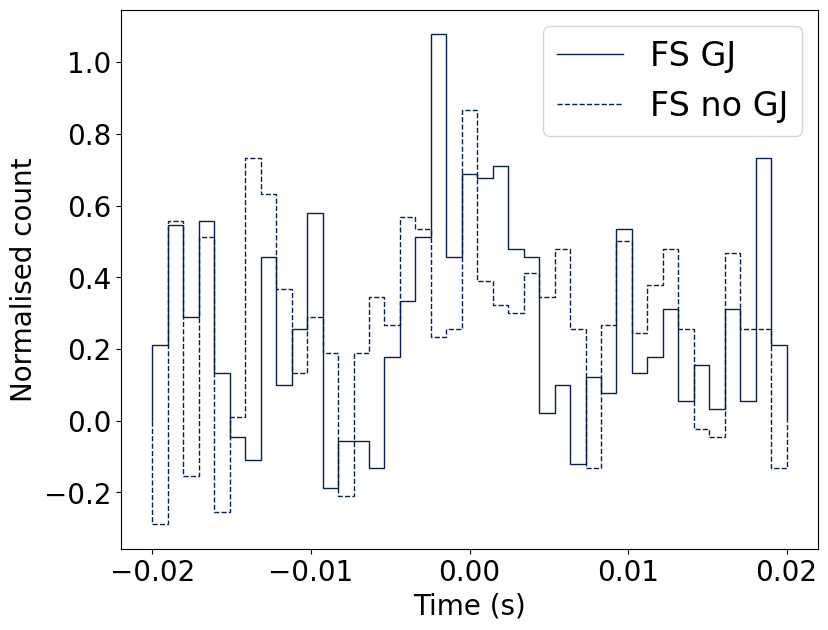

<Figure size 640x480 with 0 Axes>

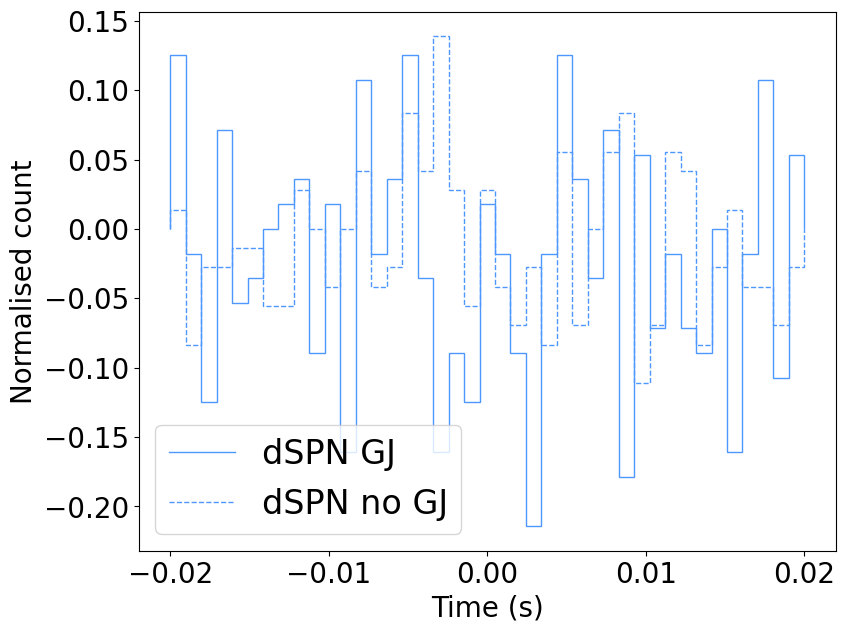

<Figure size 640x480 with 0 Axes>

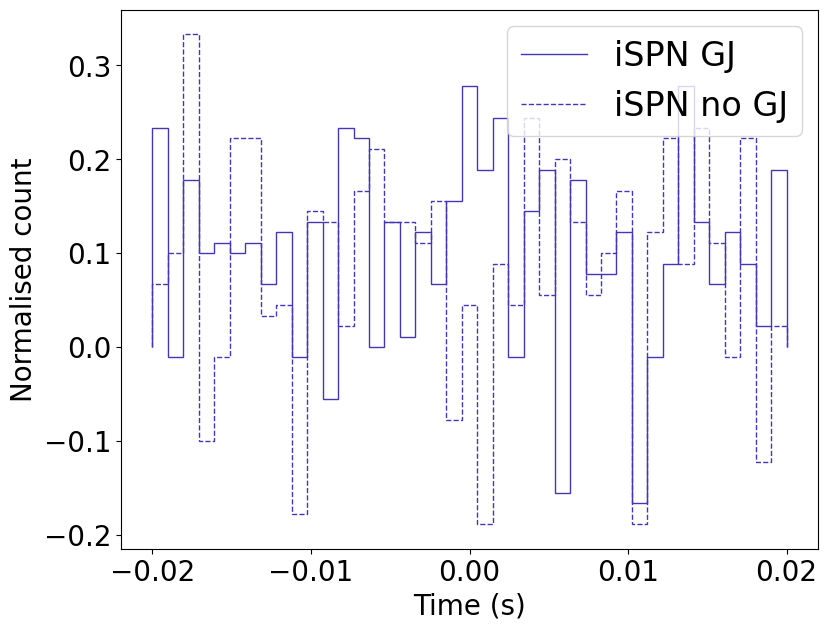

<AxesSubplot:xlabel='Time (s)', ylabel='Normalised count'>

<Figure size 640x480 with 0 Axes>

In [16]:
from snudda.plotting.plot_cross_correlogram import PlotCrossCorrelogram

fig_file_fs=os.path.join(fig_path, f"{input_name}-shuffle-corrected-cross-correlogram-FS.png")
fig_file_dspn=os.path.join(fig_path, f"{input_name}-shuffle-corrected-cross-correlogram-dSPN.png")
fig_file_ispn=os.path.join(fig_path, f"{input_name}-shuffle-corrected-cross-correlogram-iSPN.png")

pcc = PlotCrossCorrelogram(simulation_file=sim_file_gj, snudda_simulation_load=sls_gj)
pcc2 = PlotCrossCorrelogram(simulation_file=sim_file_nogj, snudda_simulation_load=sls_nogj)

fs_colour = spr.get_colours("FS")
dspn_colour = spr.get_colours("dSPN")
ispn_colour = spr.get_colours("iSPN")

# Pick centre FS only, use same number as for dSPN
nid_fs_center = [x for x, y in sl.get_centre_neurons_iterator(neuron_type="FS", n_neurons=len(nid_dspn))]

n_bins= 41
width = 20e-3

ax = pcc.plot_all_pair_cross_correlogram(neuron_id=nid_fs_center, show_figure=False, linestyle="-", label="FS GJ", colour=fs_colour, n_bins=n_bins, width=width, fig_size=(9,7))
pcc2.plot_all_pair_cross_correlogram(neuron_id=nid_fs_center, show_figure=True, linestyle="--", ax=ax, label="FS no GJ", fig_file_name=fig_file_fs, colour=fs_colour, n_bins=n_bins, width=width)

ax = pcc.plot_all_pair_cross_correlogram(neuron_id=nid_dspn, show_figure=False, linestyle="-", label="dSPN GJ", colour=dspn_colour, n_bins=n_bins, width=width, fig_size=(9,7))
pcc2.plot_all_pair_cross_correlogram(neuron_id=nid_dspn, show_figure=True, linestyle="--", ax=ax, label="dSPN no GJ", fig_file_name=fig_file_dspn, colour=dspn_colour, n_bins=n_bins, width=width)

ax = pcc.plot_all_pair_cross_correlogram(neuron_id=nid_ispn, show_figure=False, linestyle="-", label="iSPN GJ", colour=ispn_colour, n_bins=n_bins, width=width, fig_size=(9,7))
pcc2.plot_all_pair_cross_correlogram(neuron_id=nid_ispn, show_figure=True, linestyle="--", ax=ax, label="iSPN no GJ", fig_file_name=fig_file_ispn, colour=ispn_colour, n_bins=n_bins, width=width)